CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) for convolutional sparse coding with a spatial mask [[29]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-boundary). The example problem is inpainting of randomly distributed corruption of a greyscale image.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco import util
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 gray=True, idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
t = 0.5
np.random.seed(12345)
msk = np.random.randn(*(img.shape))
msk[np.abs(msk) > t] = 1;
msk[np.abs(msk) < t] = 0;
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x:  np.pad(x, pn, mode='symmetric')
zpad = lambda x:  np.pad(x, pn, mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

:math:`\ell_2`-TV denoising with a spatial mask as a non-linear lowpass
filter.

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                    'DFidWeight': mskp, 'gEvalY': False,
                    'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt)
sl = b.solve()
sh = imgwp - sl

Load dictionary.

In [7]:
D = util.convdicts()['G:8x8x128']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [8]:
lmbda = 2e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 250,
                    'HighMemSolve': True, 'RelStopTol': 1e-3,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'AutoRho': {'Enabled': False,
                    'StdResiduals': True}})

Construct [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) wrapper for :class`.admm.cbpdn.ConvBPDN` and solve via wrapper. This example could also have made use of :class`.admm.cbpdn.ConvBPDNMaskDcpl`, which has very similar performance in this application, but [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) has the advantage of greater flexibility in that the wrapper can be applied to a variety of CSC solver objects.

In [9]:
ams = cbpdn.AddMaskSim(cbpdn.ConvBPDN, D, sh, mskp, lmbda, opt=opt)
X = ams.solve()

Itn   Fnc       DFid      Regℓ1     r         s         
------------------------------------------------------


   0  6.09e+02  2.47e+02  1.81e+04  1.99e+01  2.85e+01


   1  4.81e+02  2.81e+02  1.00e+04  1.71e+01  3.09e+01


   2  2.11e+02  3.51e+01  8.79e+03  6.39e+00  1.18e+01


   3  1.68e+02  1.29e+01  7.73e+03  4.51e+00  7.86e+00


   4  1.39e+02  6.72e+00  6.61e+03  3.64e+00  6.04e+00


   5  1.17e+02  4.62e+00  5.63e+03  3.08e+00  5.01e+00


   6  1.03e+02  3.68e+00  4.95e+03  2.71e+00  4.36e+00


   7  9.37e+01  3.02e+00  4.53e+03  2.43e+00  3.82e+00


   8  8.56e+01  2.57e+00  4.15e+03  2.20e+00  3.40e+00


   9  7.87e+01  2.28e+00  3.82e+03  2.00e+00  3.07e+00


  10  7.26e+01  2.08e+00  3.53e+03  1.84e+00  2.83e+00


  11  6.70e+01  1.95e+00  3.25e+03  1.70e+00  2.65e+00


  12  6.19e+01  1.86e+00  3.00e+03  1.58e+00  2.51e+00


  13  5.76e+01  1.78e+00  2.79e+03  1.48e+00  2.38e+00


  14  5.43e+01  1.71e+00  2.63e+03  1.40e+00  2.26e+00


  15  5.19e+01  1.63e+00  2.51e+03  1.33e+00  2.14e+00


  16  5.02e+01  1.56e+00  2.43e+03  1.27e+00  2.01e+00


  17  4.88e+01  1.49e+00  2.37e+03  1.22e+00  1.88e+00


  18  4.76e+01  1.44e+00  2.31e+03  1.17e+00  1.76e+00


  19  4.63e+01  1.40e+00  2.25e+03  1.12e+00  1.66e+00


  20  4.49e+01  1.37e+00  2.18e+03  1.08e+00  1.58e+00


  21  4.36e+01  1.36e+00  2.11e+03  1.04e+00  1.52e+00


  22  4.23e+01  1.34e+00  2.05e+03  9.99e-01  1.46e+00


  23  4.13e+01  1.34e+00  2.00e+03  9.66e-01  1.41e+00


  24  4.03e+01  1.33e+00  1.95e+03  9.35e-01  1.35e+00


  25  3.94e+01  1.32e+00  1.90e+03  9.07e-01  1.31e+00


  26  3.84e+01  1.32e+00  1.85e+03  8.79e-01  1.27e+00


  27  3.75e+01  1.32e+00  1.81e+03  8.52e-01  1.24e+00


  28  3.65e+01  1.32e+00  1.76e+03  8.27e-01  1.21e+00


  29  3.56e+01  1.32e+00  1.72e+03  8.03e-01  1.18e+00


  30  3.48e+01  1.32e+00  1.67e+03  7.81e-01  1.16e+00


  31  3.40e+01  1.32e+00  1.63e+03  7.60e-01  1.14e+00


  32  3.33e+01  1.32e+00  1.60e+03  7.40e-01  1.11e+00


  33  3.26e+01  1.32e+00  1.57e+03  7.21e-01  1.09e+00


  34  3.20e+01  1.32e+00  1.54e+03  7.03e-01  1.06e+00


  35  3.14e+01  1.32e+00  1.51e+03  6.86e-01  1.04e+00


  36  3.08e+01  1.32e+00  1.47e+03  6.70e-01  1.01e+00


  37  3.02e+01  1.32e+00  1.44e+03  6.54e-01  9.90e-01


  38  2.95e+01  1.32e+00  1.41e+03  6.39e-01  9.70e-01


  39  2.89e+01  1.32e+00  1.38e+03  6.24e-01  9.51e-01


  40  2.83e+01  1.33e+00  1.35e+03  6.10e-01  9.32e-01


  41  2.78e+01  1.34e+00  1.32e+03  5.97e-01  9.13e-01


  42  2.73e+01  1.34e+00  1.30e+03  5.84e-01  8.96e-01


  43  2.68e+01  1.35e+00  1.27e+03  5.72e-01  8.79e-01


  44  2.64e+01  1.36e+00  1.25e+03  5.60e-01  8.62e-01


  45  2.60e+01  1.37e+00  1.23e+03  5.49e-01  8.46e-01


  46  2.57e+01  1.37e+00  1.22e+03  5.38e-01  8.29e-01


  47  2.54e+01  1.38e+00  1.20e+03  5.28e-01  8.13e-01


  48  2.51e+01  1.38e+00  1.18e+03  5.18e-01  7.97e-01


  49  2.48e+01  1.39e+00  1.17e+03  5.09e-01  7.80e-01


  50  2.45e+01  1.39e+00  1.16e+03  5.00e-01  7.65e-01


  51  2.42e+01  1.40e+00  1.14e+03  4.91e-01  7.51e-01


  52  2.39e+01  1.40e+00  1.12e+03  4.82e-01  7.38e-01


  53  2.36e+01  1.40e+00  1.11e+03  4.73e-01  7.26e-01


  54  2.33e+01  1.41e+00  1.09e+03  4.65e-01  7.14e-01


  55  2.30e+01  1.41e+00  1.08e+03  4.57e-01  7.03e-01


  56  2.27e+01  1.41e+00  1.06e+03  4.49e-01  6.92e-01


  57  2.24e+01  1.41e+00  1.05e+03  4.42e-01  6.81e-01


  58  2.21e+01  1.42e+00  1.04e+03  4.35e-01  6.70e-01


  59  2.19e+01  1.42e+00  1.02e+03  4.28e-01  6.59e-01


  60  2.16e+01  1.42e+00  1.01e+03  4.21e-01  6.49e-01


  61  2.14e+01  1.42e+00  1.00e+03  4.15e-01  6.39e-01


  62  2.12e+01  1.42e+00  9.88e+02  4.09e-01  6.29e-01


  63  2.09e+01  1.42e+00  9.76e+02  4.02e-01  6.20e-01


  64  2.07e+01  1.43e+00  9.65e+02  3.96e-01  6.11e-01


  65  2.05e+01  1.43e+00  9.54e+02  3.91e-01  6.02e-01


  66  2.03e+01  1.43e+00  9.43e+02  3.85e-01  5.93e-01


  67  2.01e+01  1.43e+00  9.33e+02  3.80e-01  5.84e-01


  68  1.99e+01  1.43e+00  9.24e+02  3.75e-01  5.75e-01


  69  1.97e+01  1.43e+00  9.15e+02  3.70e-01  5.66e-01


  70  1.96e+01  1.43e+00  9.06e+02  3.65e-01  5.57e-01


  71  1.94e+01  1.43e+00  8.98e+02  3.60e-01  5.48e-01


  72  1.92e+01  1.43e+00  8.90e+02  3.55e-01  5.39e-01


  73  1.91e+01  1.43e+00  8.82e+02  3.51e-01  5.30e-01


  74  1.89e+01  1.44e+00  8.74e+02  3.46e-01  5.22e-01


  75  1.88e+01  1.44e+00  8.66e+02  3.42e-01  5.14e-01


  76  1.86e+01  1.44e+00  8.58e+02  3.38e-01  5.07e-01


  77  1.84e+01  1.44e+00  8.50e+02  3.33e-01  5.01e-01


  78  1.83e+01  1.45e+00  8.42e+02  3.29e-01  4.95e-01


  79  1.81e+01  1.45e+00  8.33e+02  3.25e-01  4.89e-01


  80  1.80e+01  1.45e+00  8.25e+02  3.21e-01  4.84e-01


  81  1.78e+01  1.45e+00  8.17e+02  3.17e-01  4.79e-01


  82  1.76e+01  1.46e+00  8.09e+02  3.13e-01  4.74e-01


  83  1.75e+01  1.46e+00  8.01e+02  3.09e-01  4.70e-01


  84  1.73e+01  1.46e+00  7.92e+02  3.05e-01  4.66e-01


  85  1.71e+01  1.47e+00  7.83e+02  3.02e-01  4.63e-01


  86  1.70e+01  1.47e+00  7.75e+02  2.98e-01  4.60e-01


  87  1.68e+01  1.47e+00  7.66e+02  2.94e-01  4.57e-01


  88  1.66e+01  1.47e+00  7.58e+02  2.91e-01  4.54e-01


  89  1.65e+01  1.48e+00  7.50e+02  2.87e-01  4.51e-01


  90  1.63e+01  1.48e+00  7.43e+02  2.84e-01  4.48e-01


  91  1.62e+01  1.48e+00  7.36e+02  2.81e-01  4.45e-01


  92  1.61e+01  1.48e+00  7.30e+02  2.78e-01  4.41e-01


  93  1.60e+01  1.48e+00  7.25e+02  2.75e-01  4.37e-01


  94  1.59e+01  1.48e+00  7.20e+02  2.72e-01  4.33e-01


  95  1.58e+01  1.48e+00  7.15e+02  2.69e-01  4.28e-01


  96  1.57e+01  1.48e+00  7.11e+02  2.67e-01  4.23e-01


  97  1.56e+01  1.49e+00  7.07e+02  2.64e-01  4.17e-01


  98  1.56e+01  1.49e+00  7.04e+02  2.62e-01  4.12e-01


  99  1.55e+01  1.49e+00  7.00e+02  2.59e-01  4.06e-01


 100  1.54e+01  1.49e+00  6.97e+02  2.57e-01  4.00e-01


 101  1.54e+01  1.49e+00  6.93e+02  2.55e-01  3.94e-01


 102  1.53e+01  1.49e+00  6.89e+02  2.53e-01  3.88e-01


 103  1.52e+01  1.49e+00  6.85e+02  2.50e-01  3.82e-01


 104  1.51e+01  1.49e+00  6.81e+02  2.48e-01  3.77e-01


 105  1.50e+01  1.49e+00  6.77e+02  2.46e-01  3.71e-01


 106  1.49e+01  1.49e+00  6.72e+02  2.44e-01  3.67e-01


 107  1.48e+01  1.49e+00  6.68e+02  2.42e-01  3.62e-01


 108  1.48e+01  1.49e+00  6.63e+02  2.40e-01  3.58e-01


 109  1.47e+01  1.50e+00  6.58e+02  2.38e-01  3.54e-01


 110  1.46e+01  1.50e+00  6.54e+02  2.35e-01  3.51e-01


 111  1.45e+01  1.50e+00  6.50e+02  2.33e-01  3.48e-01


 112  1.44e+01  1.50e+00  6.46e+02  2.31e-01  3.45e-01


 113  1.43e+01  1.50e+00  6.41e+02  2.29e-01  3.43e-01


 114  1.43e+01  1.50e+00  6.37e+02  2.27e-01  3.41e-01


 115  1.42e+01  1.50e+00  6.34e+02  2.25e-01  3.39e-01


 116  1.41e+01  1.50e+00  6.30e+02  2.22e-01  3.37e-01


 117  1.40e+01  1.50e+00  6.26e+02  2.20e-01  3.35e-01


 118  1.40e+01  1.51e+00  6.22e+02  2.18e-01  3.34e-01


 119  1.39e+01  1.51e+00  6.19e+02  2.16e-01  3.32e-01


 120  1.38e+01  1.51e+00  6.15e+02  2.14e-01  3.31e-01


 121  1.37e+01  1.51e+00  6.11e+02  2.12e-01  3.29e-01


 122  1.37e+01  1.51e+00  6.07e+02  2.10e-01  3.28e-01


 123  1.36e+01  1.51e+00  6.03e+02  2.08e-01  3.26e-01


 124  1.35e+01  1.51e+00  5.99e+02  2.07e-01  3.25e-01


 125  1.34e+01  1.51e+00  5.95e+02  2.05e-01  3.23e-01


 126  1.33e+01  1.51e+00  5.92e+02  2.03e-01  3.21e-01


 127  1.33e+01  1.51e+00  5.88e+02  2.01e-01  3.18e-01


 128  1.32e+01  1.51e+00  5.84e+02  2.00e-01  3.16e-01


 129  1.31e+01  1.51e+00  5.81e+02  1.98e-01  3.14e-01


 130  1.31e+01  1.51e+00  5.78e+02  1.97e-01  3.11e-01


 131  1.30e+01  1.52e+00  5.75e+02  1.95e-01  3.09e-01


 132  1.30e+01  1.52e+00  5.72e+02  1.94e-01  3.06e-01


 133  1.29e+01  1.52e+00  5.69e+02  1.92e-01  3.03e-01


 134  1.28e+01  1.52e+00  5.67e+02  1.91e-01  3.00e-01


 135  1.28e+01  1.52e+00  5.64e+02  1.90e-01  2.97e-01


 136  1.28e+01  1.52e+00  5.62e+02  1.88e-01  2.93e-01


 137  1.27e+01  1.52e+00  5.60e+02  1.87e-01  2.90e-01


 138  1.27e+01  1.52e+00  5.59e+02  1.86e-01  2.87e-01


 139  1.27e+01  1.52e+00  5.57e+02  1.84e-01  2.84e-01


 140  1.26e+01  1.52e+00  5.55e+02  1.83e-01  2.80e-01


 141  1.26e+01  1.52e+00  5.54e+02  1.82e-01  2.77e-01


 142  1.26e+01  1.52e+00  5.52e+02  1.81e-01  2.74e-01


 143  1.25e+01  1.52e+00  5.50e+02  1.80e-01  2.71e-01


 144  1.25e+01  1.52e+00  5.48e+02  1.78e-01  2.69e-01


 145  1.24e+01  1.52e+00  5.45e+02  1.77e-01  2.66e-01


 146  1.24e+01  1.52e+00  5.43e+02  1.76e-01  2.64e-01


 147  1.23e+01  1.52e+00  5.40e+02  1.75e-01  2.62e-01


 148  1.23e+01  1.52e+00  5.37e+02  1.73e-01  2.61e-01


 149  1.22e+01  1.52e+00  5.34e+02  1.72e-01  2.59e-01


 150  1.22e+01  1.53e+00  5.31e+02  1.71e-01  2.58e-01


 151  1.21e+01  1.53e+00  5.29e+02  1.69e-01  2.57e-01


 152  1.20e+01  1.53e+00  5.26e+02  1.68e-01  2.56e-01


 153  1.20e+01  1.53e+00  5.23e+02  1.67e-01  2.55e-01


 154  1.19e+01  1.53e+00  5.21e+02  1.66e-01  2.54e-01


 155  1.19e+01  1.53e+00  5.18e+02  1.64e-01  2.53e-01


 156  1.18e+01  1.53e+00  5.16e+02  1.63e-01  2.52e-01


 157  1.18e+01  1.53e+00  5.14e+02  1.62e-01  2.50e-01


 158  1.18e+01  1.53e+00  5.12e+02  1.61e-01  2.49e-01


 159  1.17e+01  1.53e+00  5.10e+02  1.60e-01  2.48e-01


 160  1.17e+01  1.53e+00  5.08e+02  1.59e-01  2.47e-01


 161  1.17e+01  1.53e+00  5.07e+02  1.58e-01  2.45e-01


 162  1.16e+01  1.53e+00  5.05e+02  1.56e-01  2.44e-01


 163  1.16e+01  1.53e+00  5.03e+02  1.55e-01  2.43e-01


 164  1.16e+01  1.53e+00  5.02e+02  1.54e-01  2.41e-01


 165  1.15e+01  1.53e+00  5.00e+02  1.53e-01  2.40e-01


 166  1.15e+01  1.54e+00  4.98e+02  1.52e-01  2.38e-01


 167  1.15e+01  1.54e+00  4.97e+02  1.51e-01  2.37e-01


 168  1.14e+01  1.54e+00  4.95e+02  1.50e-01  2.35e-01


 169  1.14e+01  1.54e+00  4.93e+02  1.49e-01  2.34e-01


 170  1.14e+01  1.54e+00  4.91e+02  1.48e-01  2.32e-01


 171  1.13e+01  1.54e+00  4.90e+02  1.48e-01  2.31e-01


 172  1.13e+01  1.54e+00  4.88e+02  1.47e-01  2.29e-01


 173  1.13e+01  1.54e+00  4.86e+02  1.46e-01  2.28e-01


 174  1.12e+01  1.54e+00  4.84e+02  1.45e-01  2.26e-01


 175  1.12e+01  1.54e+00  4.83e+02  1.44e-01  2.24e-01


 176  1.12e+01  1.54e+00  4.81e+02  1.43e-01  2.23e-01


 177  1.11e+01  1.54e+00  4.80e+02  1.42e-01  2.21e-01


 178  1.11e+01  1.54e+00  4.78e+02  1.42e-01  2.19e-01


 179  1.11e+01  1.54e+00  4.77e+02  1.41e-01  2.17e-01


 180  1.11e+01  1.54e+00  4.76e+02  1.40e-01  2.16e-01


 181  1.10e+01  1.54e+00  4.75e+02  1.39e-01  2.14e-01


 182  1.10e+01  1.54e+00  4.73e+02  1.38e-01  2.12e-01


 183  1.10e+01  1.54e+00  4.72e+02  1.38e-01  2.11e-01


 184  1.10e+01  1.54e+00  4.71e+02  1.37e-01  2.09e-01


 185  1.09e+01  1.54e+00  4.70e+02  1.36e-01  2.07e-01


 186  1.09e+01  1.54e+00  4.69e+02  1.35e-01  2.06e-01


 187  1.09e+01  1.54e+00  4.68e+02  1.34e-01  2.04e-01


 188  1.09e+01  1.54e+00  4.67e+02  1.34e-01  2.03e-01


 189  1.09e+01  1.54e+00  4.66e+02  1.33e-01  2.02e-01


 190  1.08e+01  1.54e+00  4.65e+02  1.32e-01  2.01e-01


 191  1.08e+01  1.54e+00  4.63e+02  1.31e-01  2.00e-01


 192  1.08e+01  1.54e+00  4.62e+02  1.30e-01  1.99e-01


 193  1.07e+01  1.54e+00  4.60e+02  1.30e-01  1.98e-01


 194  1.07e+01  1.54e+00  4.59e+02  1.29e-01  1.97e-01


 195  1.07e+01  1.54e+00  4.57e+02  1.28e-01  1.96e-01


 196  1.06e+01  1.54e+00  4.55e+02  1.27e-01  1.95e-01


 197  1.06e+01  1.54e+00  4.54e+02  1.27e-01  1.94e-01


 198  1.06e+01  1.54e+00  4.52e+02  1.26e-01  1.93e-01


 199  1.06e+01  1.54e+00  4.51e+02  1.25e-01  1.93e-01


 200  1.05e+01  1.54e+00  4.49e+02  1.24e-01  1.92e-01


 201  1.05e+01  1.54e+00  4.48e+02  1.24e-01  1.91e-01


 202  1.05e+01  1.54e+00  4.47e+02  1.23e-01  1.90e-01


 203  1.05e+01  1.55e+00  4.46e+02  1.22e-01  1.89e-01


 204  1.04e+01  1.55e+00  4.45e+02  1.21e-01  1.88e-01


 205  1.04e+01  1.55e+00  4.43e+02  1.21e-01  1.87e-01


 206  1.04e+01  1.55e+00  4.42e+02  1.20e-01  1.87e-01


 207  1.04e+01  1.55e+00  4.41e+02  1.19e-01  1.86e-01


 208  1.04e+01  1.55e+00  4.40e+02  1.19e-01  1.85e-01


 209  1.03e+01  1.55e+00  4.40e+02  1.18e-01  1.84e-01


 210  1.03e+01  1.55e+00  4.39e+02  1.17e-01  1.84e-01


 211  1.03e+01  1.55e+00  4.38e+02  1.17e-01  1.83e-01


 212  1.03e+01  1.55e+00  4.37e+02  1.16e-01  1.82e-01


 213  1.03e+01  1.55e+00  4.36e+02  1.15e-01  1.82e-01


 214  1.02e+01  1.55e+00  4.35e+02  1.15e-01  1.81e-01


 215  1.02e+01  1.55e+00  4.34e+02  1.14e-01  1.80e-01


 216  1.02e+01  1.55e+00  4.33e+02  1.13e-01  1.79e-01


 217  1.02e+01  1.55e+00  4.32e+02  1.13e-01  1.78e-01


 218  1.02e+01  1.55e+00  4.31e+02  1.12e-01  1.77e-01


 219  1.02e+01  1.55e+00  4.30e+02  1.12e-01  1.76e-01


 220  1.01e+01  1.55e+00  4.29e+02  1.11e-01  1.74e-01


 221  1.01e+01  1.55e+00  4.28e+02  1.11e-01  1.73e-01


 222  1.01e+01  1.55e+00  4.28e+02  1.10e-01  1.71e-01


 223  1.01e+01  1.55e+00  4.27e+02  1.10e-01  1.69e-01


 224  1.01e+01  1.55e+00  4.26e+02  1.09e-01  1.67e-01


 225  1.01e+01  1.55e+00  4.26e+02  1.09e-01  1.66e-01


 226  1.01e+01  1.55e+00  4.25e+02  1.08e-01  1.64e-01


 227  1.00e+01  1.55e+00  4.25e+02  1.08e-01  1.62e-01


 228  1.00e+01  1.55e+00  4.24e+02  1.08e-01  1.60e-01


 229  1.00e+01  1.55e+00  4.24e+02  1.07e-01  1.59e-01


 230  1.00e+01  1.55e+00  4.23e+02  1.07e-01  1.58e-01


 231  1.00e+01  1.55e+00  4.22e+02  1.06e-01  1.57e-01


 232  9.99e+00  1.55e+00  4.22e+02  1.05e-01  1.56e-01


 233  9.97e+00  1.55e+00  4.21e+02  1.05e-01  1.55e-01


 234  9.95e+00  1.55e+00  4.20e+02  1.04e-01  1.55e-01


 235  9.93e+00  1.55e+00  4.19e+02  1.04e-01  1.54e-01


 236  9.91e+00  1.55e+00  4.18e+02  1.03e-01  1.54e-01


 237  9.89e+00  1.55e+00  4.17e+02  1.02e-01  1.55e-01


 238  9.87e+00  1.55e+00  4.16e+02  1.02e-01  1.55e-01


 239  9.84e+00  1.55e+00  4.15e+02  1.01e-01  1.55e-01


 240  9.82e+00  1.55e+00  4.13e+02  1.00e-01  1.56e-01


 241  9.79e+00  1.55e+00  4.12e+02  9.95e-02  1.56e-01


 242  9.77e+00  1.55e+00  4.11e+02  9.88e-02  1.56e-01


 243  9.74e+00  1.55e+00  4.09e+02  9.82e-02  1.57e-01


 244  9.72e+00  1.55e+00  4.08e+02  9.76e-02  1.57e-01


 245  9.70e+00  1.55e+00  4.07e+02  9.70e-02  1.57e-01


 246  9.68e+00  1.55e+00  4.06e+02  9.65e-02  1.56e-01


 247  9.66e+00  1.55e+00  4.05e+02  9.60e-02  1.56e-01


 248  9.65e+00  1.55e+00  4.05e+02  9.55e-02  1.55e-01


 249  9.64e+00  1.55e+00  4.04e+02  9.51e-02  1.54e-01
------------------------------------------------------


Reconstruct from representation.

In [10]:
imgr = crop(sl + ams.reconstruct().squeeze())

Display solve time and reconstruction performance.

In [11]:
print("AddMaskSim wrapped ConvBPDN solve time: %.2fs" %
      ams.timer.elapsed('solve'))
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % metric.psnr(img, imgr))

AddMaskSim wrapped ConvBPDN solve time: 237.64s
Corrupted image PSNR: 10.33 dB
Recovered image PSNR: 26.66 dB


Display reference, test, and reconstructed image

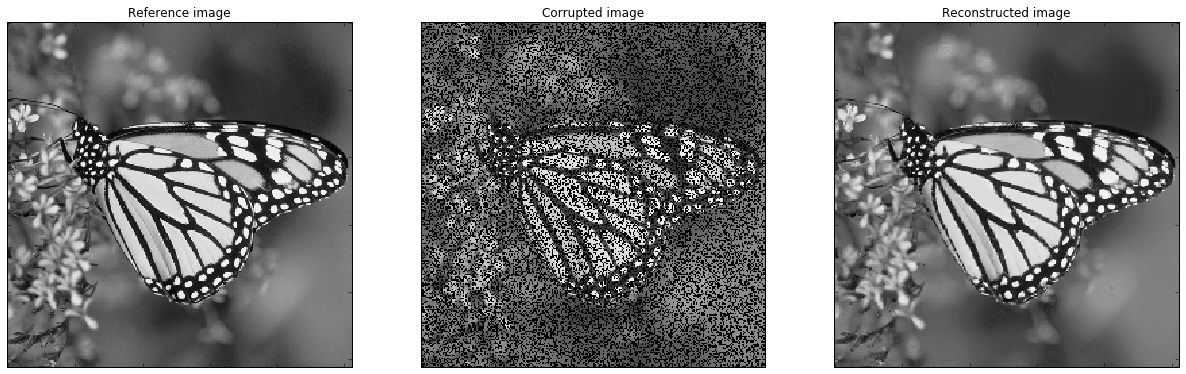

In [12]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, fgrf=fig, title='Reference image')
plot.subplot(1, 3, 2)
plot.imview(imgw, fgrf=fig, title='Corrupted image')
plot.subplot(1, 3, 3)
plot.imview(imgr, fgrf=fig, title='Reconstructed image')
fig.show()

Display lowpass component and sparse representation

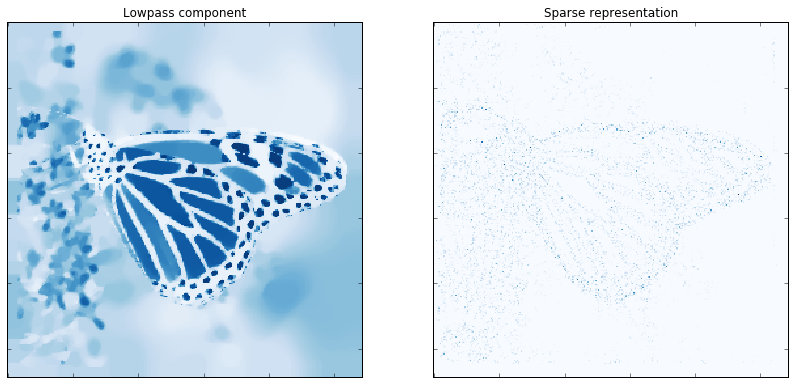

In [13]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, fgrf=fig, cmap=plot.cm.Blues, title='Lowpass component')
plot.subplot(1, 2, 2)
plot.imview(np.squeeze(np.sum(abs(X), axis=ams.cri.axisM)), fgrf=fig,
            cmap=plot.cm.Blues, title='Sparse representation')
fig.show()

Plot functional value, residuals, and rho

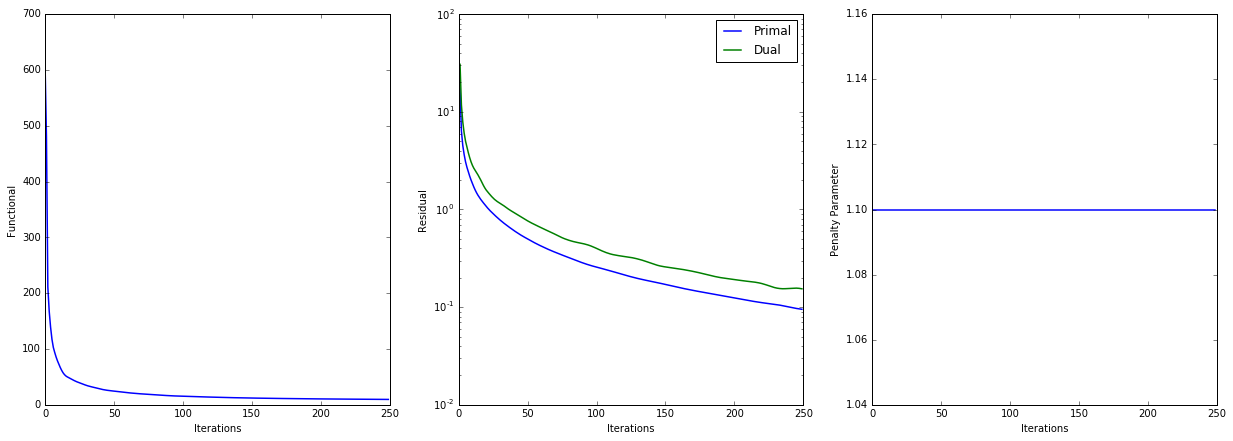

In [14]:
its = ams.getitstat()
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, fgrf=fig, xlbl='Iterations', ylbl='Functional')
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, fgrf=fig,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.subplot(1, 3, 3)
plot.plot(its.Rho, fgrf=fig, xlbl='Iterations', ylbl='Penalty Parameter')
fig.show()